# Iterative linear solvers

In [14]:
import time
import numpy as np

import matplotlib.pyplot as plt
import niceplots

plt.style.use(niceplots.get_style())
niceColors = niceplots.get_colors_list()

# Force the jupyter notebook to use vector graphics
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

## Problem definition

In this example we'll be solving the same 1D heat transfer equation as [last week's example](../Week3/FiniteDifferenceScheme.ipynb)

The 1D domain spans $0 \le x \le L$ and is split into $N$ intervals of length $\Delta x = L/N$, this gives $N+1$ nodes in the grid. The temperatures at the nodes are $T_0, T_1, \ldots, T_N$. Dirichlet boundary conditions are applied at $x=0$ and $x=L$, such that $T_0 = 1$ and $T_N=4$.

![The finite-difference grid](../../images/FDDomain.svg)

In [2]:
# Define the parameters
L = 2.0  # Length of domain
kappa = 0.5  # Thermal conductivity
Nx = 100  # Number of intervals
T0 = 1.0  # Left boundary condition
TN = 4.0  # Right boundary condition


# Define the symbolic function q(x)
def q(x, L):
    return np.sin(np.pi * x / L)

Using the central difference approximation for the second derivative, we wrote the finite difference equation at each node as:

$$ -\kappa\frac{T_{i-1} - 2T_i + T_{i+1}}{\Delta x^2} = q(x_i)$$

## The residual

The residual is the quantity that must be zero at the solution, so we can use it as a measure of the error in our solution.
Note that this is a different kind of error than we have discussed previously, it is not the error relative to the true solution of the PDE, but the error relative to the solution of the discretized system of equations we have created with our finite difference approximation.

From the above finite difference equation we can derive the residual at each node as:

$$ r_i = \frac{\kappa\left(T_{i-1} - 2T_i + T_{i+1}\right)}{\Delta x^2} + q(x_i)$$

And the residual norm, that we will use to measure the error in our solution, is:

$$ ||r||_2 = \sqrt{\sum_{i=1}^{N-1} \frac{1}{N+1}r_i^2} $$

In [3]:
def computeResidual(u, q, kappa, dx):
    """Compute the residual of the 1D heat equation

    Parameters
    ----------
    u : numpy.ndarray
        Current state vector
    q : numpy.ndarray
        Source term vector
    kappa : float
        Thermal conductivity
    dx : float
        Grid spacing

    Returns
    -------
    numpy.ndarray
        Residual vector
    """
    dx2 = dx**2
    r = np.zeros_like(u)
    r[1:-1] = kappa * (u[:-2] - 2 * u[1:-1] + u[2:]) / dx2 + q[1:-1]

    return r


def computeNorm(r):
    """Compute the "normalized" norm of a vector

    Parameters
    ----------
    r : numpy.ndarray
        Vector to compute the norm of
    """
    return np.linalg.norm(r) / np.sqrt(len(r))

Let's compute the residual for an initial guess at the solution, we'll generate a really bad initial guess by just setting all the non-boundary nodes' temperatures to zero:

In [4]:
u = np.zeros(Nx + 1)  # Initial guess
u[0] = T0  # Left boundary condition
u[-1] = TN  # Right boundary condition

x = np.linspace(0, L, Nx + 1)  # Grid points
dx = x[1] - x[0]  # Grid spacing
qVec = q(x, L)  # Source term

r = computeResidual(u, qVec, kappa, dx)  # Compute the residual
print(f"Residual norm: {np.linalg.norm(r):.2e}")

Residual norm: 5.15e+03


Surprisingly enough, it's not zero, so we need to solve the equations.
In this example we're going to to that with an iterative smoother.
Below is a general algorithm for solving a system of equation with an iterative smoother.
In each iteration we check the residual norm at the current state, if it is too high we apply one iteration of a smoother and repeat.

In [5]:
def iterativeSolve(u, q, kappa, dx, smootherFunc, tol=1e-4, maxIter=5000):
    """Iteratively solve the 1D heat equation

    Parameters
    ----------
    u : numpy.ndarray
        Initial guess
    q : numpy.ndarray
        Source term vector
    kappa : float
        Thermal conductivity
    dx : float
        Grid spacing
    tol : float, optional
        Tolerance for the residual, by default 1e-10
    maxIter : int, optional
        Maximum number of iterations, by default 400

    Returns
    -------
    numpy.ndarray
        Solution vector
    """
    resNormHistory = []
    iterationTimes = []
    printFrequency = max(1, maxIter // 10)
    startTime = time.time()
    for ii in range(maxIter):
        # Compute the residual and it's norm at the current state
        r = computeResidual(u, q, kappa, dx)
        resNorm = computeNorm(r)

        # Print some information and save the residual norm and the current time
        if ii % printFrequency == 0:
            print(f"Iteration {ii}: Res norm = {resNorm:.2e}")
        resNormHistory.append(resNorm)
        iterationTimes.append(time.time() - startTime)

        # Check for convergence or divergence
        if resNorm < tol or resNorm > 1e10 or np.isnan(resNorm):
            break

        # If we haven't converged, apply the smoother
        u = smootherFunc(u, q, kappa, dx)

    if ii % printFrequency != 0:
        print(f"Iteration {ii}: Res norm = {resNorm:.2e}")
    return u, resNormHistory, iterationTimes


The first method we will use is the Jacobi iteration. In a Jacobi iteration, we update each node in the grid by rearranging the finite difference equation to solve for $T_i$:

$$T_{i,new} = \frac{1}{2}\left(T_{i-1} + T_{i+1} + q(x_i) \frac{dx^2}{\kappa}\right)$$

In [6]:
def jacobiIteration(u, q, kappa, dx):
    """Perform one Jacobi step

    Parameters
    ----------
    u : numpy.ndarray
        Current state vector
    q : numpy.ndarray
        Source term vector
    kappa : float
        Thermal conductivity
    dx : float
        Grid spacing

    Returns
    -------
    numpy.ndarray
        Updated state vector
    """
    dx2k = dx**2 / kappa
    uNew = u.copy()
    uNew[1:-1] = 0.5 * (u[:-2] + u[2:] + q[1:-1] * dx2k)
    return uNew

An alternative smoothing method is the Gauss-Seidel iteration, it looks almost identical to the Jacobi iteration, except that we always use the most up to date state value at each node:

$$T_{i} = \frac{1}{2}\left(T_{i-1} + T_{i+1} + q(x_i) \frac{dx^2}{\kappa}\right)$$

Note how we no longer need to keep track of the old state values, we can just overwrite them with the new values as we go along.
Depending on the order that we iterate through the nodes, we can get different convergence properties because different states in the update equation will have been updated, this is called the *ordering* of the Gauss-Seidel iteration.

In [7]:
def gaussSeidelIteration(u, q, kappa, dx):
    """Perform one Gauss-Seidel smoothing step

    Parameters
    ----------
    u : numpy.ndarray
        Current state vector
    q : numpy.ndarray
        Source term vector
    kappa : float
        Thermal conductivity
    dx : float
        Grid spacing

    Returns
    -------
    numpy.ndarray
        Updated state vector
    """
    dx2k = dx**2 / kappa
    uNew = u.copy()
    for ii in range(1, len(u) - 1):
        uNew[ii] = 0.5 * (uNew[ii - 1] + uNew[ii + 1] + q[ii] * dx2k)
    return uNew

In [8]:
# Solve the system using Jacobi
tol = 5e-1
uJacobi, resNormHistoryJacobi, iterationTimesJacobi = iterativeSolve(u, qVec, kappa, dx, jacobiIteration, tol=tol)

# Solve the system using Gauss-Seidel
uJacobi, resNormHistoryGS, iterationTimesGS = iterativeSolve(u, qVec, kappa, dx, gaussSeidelIteration, tol=tol)

Iteration 0: Res norm = 5.13e+02
Iteration 500: Res norm = 4.08e+00
Iteration 1000: Res norm = 2.79e+00
Iteration 1500: Res norm = 2.13e+00
Iteration 2000: Res norm = 1.65e+00
Iteration 2500: Res norm = 1.29e+00
Iteration 3000: Res norm = 1.01e+00
Iteration 3500: Res norm = 7.88e-01
Iteration 4000: Res norm = 6.16e-01
Iteration 4422: Res norm = 5.00e-01
Iteration 0: Res norm = 5.13e+02
Iteration 500: Res norm = 2.19e+00
Iteration 1000: Res norm = 1.31e+00
Iteration 1500: Res norm = 7.98e-01
Iteration 1975: Res norm = 5.00e-01


findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not f

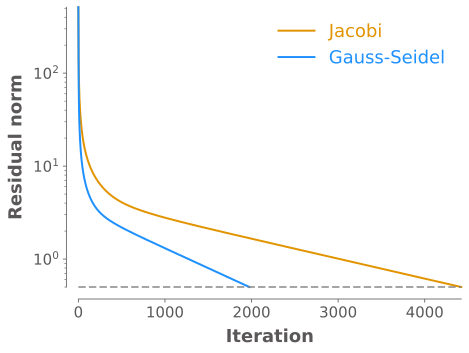

In [9]:
fig, ax = plt.subplots()
ax.set_xlabel("Iteration")
ax.set_ylabel("Residual norm")
ax.set_yscale("log")
ax.plot(resNormHistoryJacobi, color=niceColors[0], clip_on=False, label="Jacobi")
ax.plot(resNormHistoryGS, color=niceColors[1], clip_on=False, label="Gauss-Seidel")
ax.axhline(tol, color="gray", linestyle="--", clip_on=False, alpha=0.7)
ax.legend(labelcolor="linecolor")
niceplots.adjust_spines(ax)

Jacobi may take iterations, but updates for all nodes can be computed simultaneously, so each iteration is much faster than a Gauss-Seidel iteration.
In this case, the Jacobi solver actually takes less time to solve the system than Gauss-Seidel, despite taking more than twice as many iterations. 

findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: 

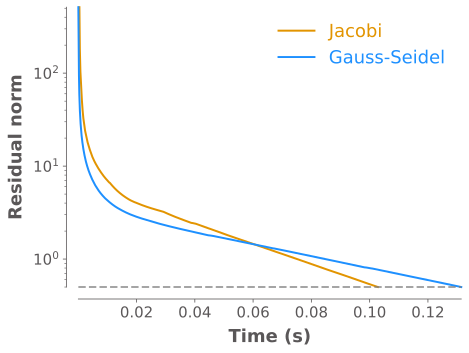

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Residual norm")
ax.set_yscale("log")
ax.plot(iterationTimesJacobi, resNormHistoryJacobi, color=niceColors[0], clip_on=False, label="Jacobi")
ax.plot(iterationTimesGS, resNormHistoryGS, color=niceColors[1], clip_on=False, label="Gauss-Seidel")
ax.axhline(tol, color="gray", linestyle="--", clip_on=False, alpha=0.7)
ax.legend(labelcolor="linecolor")
niceplots.adjust_spines(ax)

We can improve performance with under or over relaxation, where we update the nodes with a weighted average of the old and new values:

$$T_{i,new} = (1-\omega)T_{i,old} + \omega T_{i,new}$$

With Jacobi's method, we often use under-relaxation, where $\omega < 1$, to stabilize the iterative method as for some problems and initial conditions it has a tendency to diverge.
With Gauss-Seidel, we can use over-relaxation, where $\omega > 1$, to accelerate convergence.

Below is a new version of the iterative solver that allows us to specify the relaxation factor $\omega$.

In [11]:
def iterativeSolve(u, q, kappa, dx, smootherFunc, omega=1.0, tol=1e-4, maxIter=5000):
    """Iteratively solve the 1D heat equation

    Parameters
    ----------
    u : numpy.ndarray
        Initial guess
    q : numpy.ndarray
        Source term vector
    kappa : float
        Thermal conductivity
    dx : float
        Grid spacing
    tol : float, optional
        Tolerance for the residual, by default 1e-10
    maxIter : int, optional
        Maximum number of iterations, by default 400

    Returns
    -------
    numpy.ndarray
        Solution vector
    """
    resNormHistory = []
    iterationTimes = []
    printFrequency = max(1, maxIter // 10)
    startTime = time.time()
    for ii in range(maxIter):
        r = computeResidual(u, q, kappa, dx)
        resNorm = computeNorm(r)
        if ii % printFrequency == 0:
            print(f"Iteration {ii}: Res norm = {resNorm:.2e}")
        resNormHistory.append(resNorm)
        iterationTimes.append(time.time() - startTime)
        if resNorm < tol or resNorm > 1e14 or np.isnan(resNorm):
            break
        u = omega * smootherFunc(u, q, kappa, dx) + (1 - omega) * u

    if ii % printFrequency != 0:
        print(f"Iteration {ii}: Res norm = {resNorm:.2e}")

    return u, resNormHistory, iterationTimes

Now let's compare the number of iterations and time required to solve the problem with Jacobi and Gauss-Seidel, where Gauss-Seidel uses over-relaxation with $\omega=1.5$.

In [12]:
uJacobi, resNormHistoryJacobi, iterationTimesJacobi = iterativeSolve(
    u, qVec, kappa, dx, jacobiIteration, tol=tol, omega=1.0
)

resNormHistories = []
iterationTimes = []
omegas = [1.0, 1.4, 1.6, 1.8]
for omega in omegas:
    uGS, resNormHistoryGS, iterationTimesGS = iterativeSolve(
        u, qVec, kappa, dx, gaussSeidelIteration, tol=tol, omega=omega
    )
    resNormHistories.append(resNormHistoryGS)
    iterationTimes.append(iterationTimesGS)

Iteration 0: Res norm = 5.13e+02
Iteration 500: Res norm = 4.08e+00
Iteration 1000: Res norm = 2.79e+00
Iteration 1500: Res norm = 2.13e+00
Iteration 2000: Res norm = 1.65e+00
Iteration 2500: Res norm = 1.29e+00
Iteration 3000: Res norm = 1.01e+00
Iteration 3500: Res norm = 7.88e-01
Iteration 4000: Res norm = 6.16e-01
Iteration 4422: Res norm = 5.00e-01
Iteration 0: Res norm = 5.13e+02
Iteration 500: Res norm = 2.19e+00
Iteration 1000: Res norm = 1.31e+00
Iteration 1500: Res norm = 7.98e-01
Iteration 1975: Res norm = 5.00e-01
Iteration 0: Res norm = 5.13e+02
Iteration 500: Res norm = 1.77e+00
Iteration 1000: Res norm = 8.81e-01
Iteration 1410: Res norm = 5.00e-01
Iteration 0: Res norm = 5.13e+02
Iteration 500: Res norm = 1.59e+00
Iteration 1000: Res norm = 7.23e-01
Iteration 1234: Res norm = 5.00e-01
Iteration 0: Res norm = 5.13e+02
Iteration 81: Res norm = 1.05e+14


findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: 

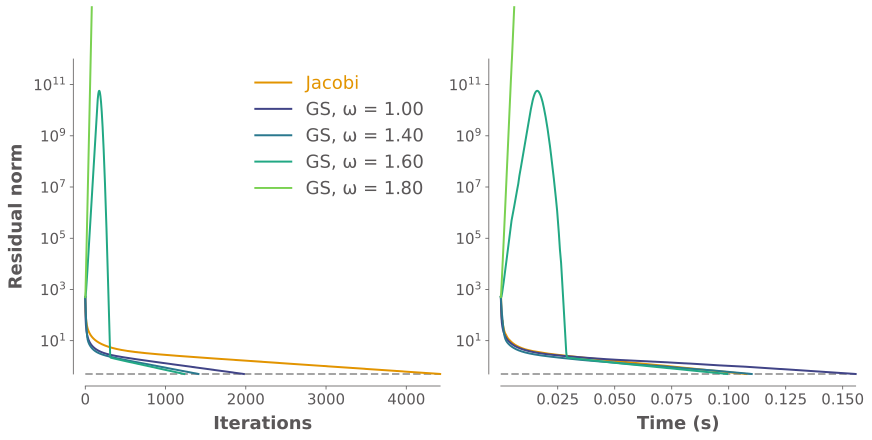

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))
axes[0].set_xlabel("Iterations")
axes[1].set_xlabel("Time (s)")
axes[0].set_ylabel("Residual norm")
for ax in axes:
    ax.set_yscale("log")
    ax.axhline(tol, color="gray", linestyle="--", clip_on=False, alpha=0.7)
    niceplots.adjust_spines(ax)

axes[0].plot(resNormHistoryJacobi, color=niceColors[0], clip_on=False, label="Jacobi")
axes[1].plot(iterationTimesJacobi, resNormHistoryJacobi, color=niceColors[0], clip_on=False, label="Jacobi")

omegaColours = plt.get_cmap("viridis")(np.linspace(0.2, 0.8, len(omegas)))
for ii in range(len(omegas)):
    axes[0].plot(resNormHistories[ii], color=omegaColours[ii], clip_on=False, label=f"GS, $\\omega$ = {omegas[ii]:.2f}")
    axes[1].plot(
        iterationTimes[ii],
        resNormHistories[ii],
        color=omegaColours[ii],
        clip_on=False,
        label=f"GS, $\\omega$ = {omegas[ii]:.2f}",
    )

axes[0].legend(labelcolor="linecolor")
axes[0].set_ylim(top=1e12)
plt.show()